<a href="https://colab.research.google.com/github/CristianDavid010/proyecto-ML/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔍 Resumen de Datos:
                 Modelo  Precio  RAM_GB  Almacenamiento_GB    Marca  \
0             iPhone 13     999       4                128    Apple   
1           Samsung S21     899       8                256  Samsung   
2  Xiaomi Redmi Note 10     299       6                128   Xiaomi   
3               Pixel 6     699       8                256   Google   
4             OnePlus 9     729      12                256  OnePlus   

   Ventas_2023  Ingresos_Cliente  Deuda_Cliente  Historial_Crediticio  \
0         1200           5000000         800000                     0   
1          950           7000000        1500000                     0   
2         1500           3000000         800000                     0   
3          800           3000000        1500000                     1   
4          600           7000000         800000                     1   

  Nivel_Endeudamiento  Peso_Envio_Kg  Costo_Envio  Aprobado_Credito  
0               Medio             10       

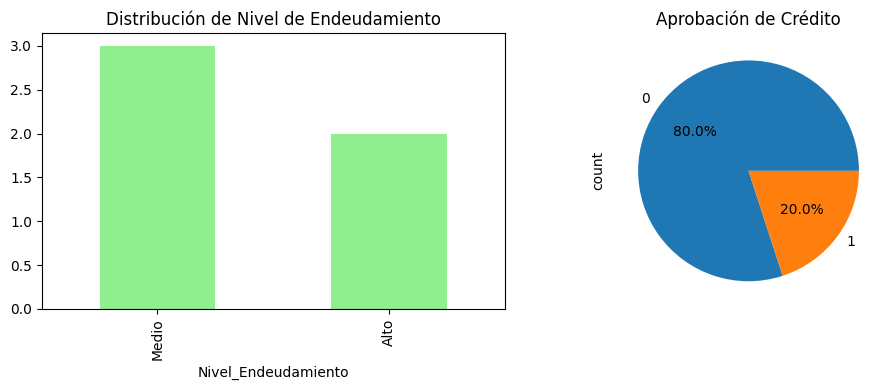

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5903103b5ef3222a80.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import gradio as gr

# --- Dataset de Celulares (ampliado) ---
data = {
    "Modelo": ["iPhone 13", "Samsung S21", "Xiaomi Redmi Note 10", "Pixel 6", "OnePlus 9"],
    "Precio": [999, 899, 299, 699, 729],
    "RAM_GB": [4, 8, 6, 8, 12],
    "Almacenamiento_GB": [128, 256, 128, 256, 256],
    "Marca": ["Apple", "Samsung", "Xiaomi", "Google", "OnePlus"],
    "Ventas_2025": [1200, 950, 1500, 800, 600],
    # --- Nuevas variables ---
    "Ingresos_Cliente": np.random.choice([5000000, 3000000, 7000000], 5),  # Ingresos mensuales del cliente
    "Deuda_Cliente": np.random.choice([1500000, 800000, 2000000], 5),  # Deuda actual
    "Historial_Crediticio": np.random.choice([0, 1], 5),  # 0=Malo, 1=Bueno
    "Nivel_Endeudamiento": np.random.choice(["Bajo", "Medio", "Alto"], 5),
    "Peso_Envio_Kg": np.random.choice([10, 15, 20], 5),  # Peso del envío
    "Costo_Envio": np.random.choice([10000, 15000, 20000], 5),  # Costo asociado
}

df = pd.DataFrame(data)

# --- Función para aprobar crédito ---
def aprobar_credito(row):
    ratio_deuda = row['Deuda_Cliente'] / row['Ingresos_Cliente']
    if (row['Historial_Crediticio'] == 1) and (ratio_deuda < 0.5):
        return 1  # Aprobado
    else:
        return 0  # Rechazado

df['Aprobado_Credito'] = df.apply(aprobar_credito, axis=1)

# --- Análisis de Datos ---
print("\n🔍 Resumen de Datos:")
print(df.head())

# Gráfico: Nivel de Endeudamiento vs Aprobación de Crédito
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['Nivel_Endeudamiento'].value_counts().plot(kind='bar', color='lightgreen')
plt.title("Distribución de Nivel de Endeudamiento")

plt.subplot(1, 2, 2)
df['Aprobado_Credito'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Aprobación de Crédito")
plt.tight_layout()
plt.show()

# --- Modelo de Recomendación (KNN) ---
X = df[["Precio", "RAM_GB", "Almacenamiento_GB"]]
knn = NearestNeighbors(n_neighbors=2)
knn.fit(X)

def recomendar_celular(precio, ram, almacenamiento):
    query = np.array([[precio, ram, almacenamiento]])
    distances, indices = knn.kneighbors(query)
    return df.iloc[indices[0]]

# --- Interfaz con Gradio (Ahora incluye crédito y envío) ---
def interfaz_completa(precio, ram, almacenamiento, ingresos, deuda, historial):
    # Recomendación
    recomendaciones = recomendar_celular(precio, ram, almacenamiento)

    # Simular aprobación de crédito
    ratio_deuda = deuda / ingresos
    credito_aprobado = 1 if (historial == 1 and ratio_deuda < 0.5) else 0

    # Calcular costo de envío (ejemplo simplificado)
    peso_envio = np.random.choice([10, 15, 20])
    costo_envio = peso_envio * 1000  # $1000 por kg

    return {
        "Recomendación": recomendaciones[["Modelo", "Precio", "RAM_GB", "Almacenamiento_GB"]],
        "Crédito": "✅ Aprobado" if credito_aprobado == 1 else "❌ Rechazado",
        "Costo de Envío": f"${costo_envio} (Peso: {peso_envio}kg)"
    }

iface = gr.Interface(
    fn=interfaz_completa,
    inputs=[
        gr.Number(label="Precio Máximo (USD)"),
        gr.Slider(1, 12, step=1, label="RAM (GB)"),
        gr.Slider(64, 512, step=64, label="Almacenamiento (GB)"),
        gr.Number(label="Ingresos Mensuales (COP)", value=5000000),
        gr.Number(label="Deuda Actual (COP)", value=1500000),
        gr.Radio([0, 1], label="Historial Crediticio (0=Malo, 1=Bueno)")
    ],
    outputs=[
        gr.Dataframe(label="Celulares Recomendados"),
        gr.Textbox(label="Estado de Crédito"),
        gr.Textbox(label="Detalles de Envío")
    ],
    title="📱 Tienda Virtual de Celulares + Crédito"
)

iface.launch()